In [1]:
import argparse
import treegp
import numpy as np
import pandas as pd
import pickle
from datetime import datetime
from sklearn.gaussian_process.kernels import Kernel
import os
import treecorr

# plotting things
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

def comp_2pcf_treecorr(x, y, k, bin_type='TwoD'):
    """measure the anisotropic 2pcf of some data."""
    cat = treecorr.Catalog(x=x, y=y, k=k, w=None)
    kk = treecorr.KKCorrelation(min_sep=0, max_sep=0.15, nbins=17,
                                bin_type=bin_type, bin_slop=0)
    kk.process(cat)

    return kk.xi

def raw_moments(im, ordx=1, ordy=1):

    posY, posX = np.indices(im.shape)
    posY = np.flipud(posY)
    
    rmom = sum(sum(im*posX**ordx*posY**ordy))
    
    return rmom

def centroids(im):
    M10 = raw_moments(im, ordx=1, ordy=0)
    M00 = raw_moments(im, ordx=0, ordy=0)
    M01 = raw_moments(im, ordx=0, ordy=1)
    xbar = M10/M00
    ybar = M01/M00
    return xbar, ybar
    
def cent_moments(im, ordx=1, ordy=1):
    posY, posX = np.indices(im.shape)
    posY = np.flipud(posY)
    
    xbar, ybar = centroids(im)
    
    cmom = sum(sum(im*(posX-xbar)**ordx*(posY-ybar)**ordy))
    
    return cmom

def get_theta(g1, g2):
    # this give theta in degrees
    phi = np.arctan2(g2,g1)*180/np.pi
    if g1*g2> 0:
        #first, quadrant
        if g1 > 0:
            phi = phi
        #third quadrant
        else: 
            phi = phi+360
    # second quadrant
    elif g1 < 0 and g2 > 0:
        phi = phi
    # fouth quadrant
    elif g1 > 0 and g2 < 0:
        phi = phi+360 
    theta = phi/2
    return theta

def get_orient(im):
    xbar, ybar = centroids(im)
    M20 = raw_moments(im, ordx=2, ordy=0)
    M00 = raw_moments(im, ordx=0, ordy=0)
    M02 = raw_moments(im, ordx=0, ordy=2)
    M11 = raw_moments(im, ordx=1, ordy=1)
    
    mu20p = M20/M00 - xbar**2
    mu02p = M02/M00 - ybar**2
    mu11p = M11/M00 - xbar*ybar
    
    #angle in degrees
    theta = get_theta(mu20p-mu02p,2*mu11p)
    return theta

seed:   169
angle:  40.71992775069543


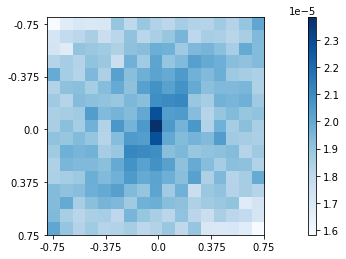

In [13]:
seed = 169
d = pickle.load(open("..//runsims//sameheightPsfws//outh_psfws_"+str(seed)+".pkl", 'rb'))
for k in ['e1', 'e2', 'thx', 'thy', 'sigma']:
    locals()[k] = np.array(d[k])
    
d_sigma = sigma - np.mean(sigma)
xi_dsigma  = comp_2pcf_treecorr(thx, thy, d_sigma)

fig, ax = plt.subplots(1,1)
imag = ax.imshow(xi_dsigma, "Blues")
divider = make_axes_locatable(ax)
ax_cb = divider.append_axes("right", size="4%")
cbar = plt.colorbar(imag, cax=ax_cb, orientation='vertical')
cbar.formatter.set_powerlimits((0, 0))
ax.set_xticks(np.linspace(0,16.5,5),np.linspace(-0.75,0.75,5))
ax.set_yticks(np.linspace(0,16.5,5),np.linspace(-0.75,0.75,5))
print("seed:  ",seed)
print("angle: ",get_orient(xi_dsigma))

seed:   153
angle:  44.31762506298223


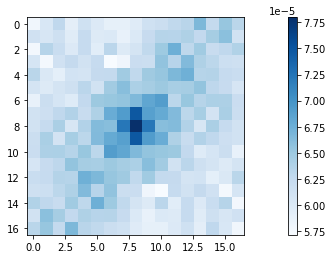

In [6]:
seed = 153
d = pickle.load(open("..//runsims//sameheightRand//outh_rand_"+str(seed)+".pkl", 'rb'))
for k in ['e1', 'e2', 'thx', 'thy', 'sigma']:
    locals()[k] = np.array(d[k])
    
d_sigma = sigma - np.mean(sigma)
xi_dsigma  = comp_2pcf_treecorr(thx, thy, e2)

fig, ax = plt.subplots(1,1)
imag = ax.imshow(xi_dsigma, "Blues")
divider = make_axes_locatable(ax)
ax_cb = divider.append_axes("right", size="4%")
cbar = plt.colorbar(imag, cax=ax_cb, orientation='vertical')
cbar.formatter.set_powerlimits((0, 0))
#ax.set_xticks(np.linspace(0,16.5,5),np.linspace(-0.75,0.75,5))
#ax.set_yticks(np.linspace(0,16.5,5),np.linspace(-0.75,0.75,5))
print("seed:  ",seed)
print("angle: ",get_orient(xi_dsigma))

In [93]:
im = xi_dsigma
xbar, ybar = centroids(im)
M20 = raw_moments(im, ordx=2, ordy=0)
M00 = raw_moments(im, ordx=0, ordy=0)
M02 = raw_moments(im, ordx=0, ordy=2)
M11 = raw_moments(im, ordx=1, ordy=1)

mu20p = M20/M00 - xbar**2
mu02p = M02/M00 - ybar**2
mu11p = M11/M00 - xbar*ybar


In [94]:
2*mu11p

2.0132039033235145

In [95]:
mu20p-mu02p

0.9624259466628189

In [7]:
M11

1.5529746951385437

In [38]:
-np.arctan2(2*mu11p,(mu20p-mu02p))*180/np.pi

169.6250114055829

In [64]:
np.arctan2(2*mu11p,(mu20p-mu02p))*180/np.pi+360

190.37498859441732

In [55]:
np.arctan2(2*mu11p,(mu20p-mu02p))*180/np.pi/2+180

95.18749429720899

In [11]:
get_theta(mu20p-mu02p, 2*mu11p)

17.06081451191006

In [12]:
print(np.arctan2(0.5,0.5)*180/np.pi)
print(np.arctan2(0.5,-0.5)*180/np.pi)
print(np.arctan2(-0.5,-0.5)*180/np.pi)
print(np.arctan2(-0.5,0.5)*180/np.pi)


45.0
135.0
-135.0
-45.0


In [13]:
print(get_theta(0.5,0.5)*2)
print(get_theta(0.5,-0.5)*2)
print(get_theta(-0.5,-0.5)*2)
print(get_theta(-0.5,0.5)*2)

45.0
315.0
315.0
135.0
